In [1]:

import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, concatenate, Reshape
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
import os

folder_path = r"C:\Users\Mishaal Aslam\Desktop\FYP\Model Training\Test"
file_name = "test.json"

# List all files in the folder
if os.path.exists(folder_path):
    print("Files in the directory:", os.listdir(folder_path))
else:
    print("Directory not found!")

Files in the directory: ['test.json']


### Data preprocess

In [3]:
# Load data
json_file_path = r"C:\Users\Mishaal Aslam\Desktop\FYP\Model Training\Test\test.json"
with open(json_file_path, 'r') as json_file:
    data = json.load(json_file)



In [4]:
df = pd.DataFrame(data)
print(len(df.columns[:-1]))

6


In [5]:
df.head()

,PhoneAccelerometer_train,PhoneGyroscope_train,PhoneMagnetometer_train,WatchAccelerometer_train,WatchGyroscope_train,WatchMagnetometer_train,Y_train
0,"[0.48843205, 0.48843205, 0.48843205, 0.4908263...","[-0.01929479, -0.01929479, -0.02173825, -0.022...","[-30.599998, -30.42, -30.0, -29.76, -29.699999...","[9.92636, 9.868899, 9.742006, 9.6845455, 9.607...","[-0.3494149, -0.33475417, -0.31520647, -0.2932...","[-37.44, -37.92, -37.8, -39.12, -39.12, -38.7,...",2
1,"[0.6751855, 0.67279124, 0.6656084, 0.6560313, ...","[-0.0058557545, -0.005244889, -0.0064666197, -...","[-30.599998, -30.42, -30.599998, -30.48, -30.3...","[9.497798, 9.490616, 9.533711, 9.548077, 9.485...","[0.004886922, 0.0036651916, -0.0012217305, -0....","[-38.46, -38.579998, -38.219997, -38.52, -38.2...",2
2,"[2.8252442, 2.6121538, 2.1021733, 1.6664152, 1...","[-0.9960683, -1.0143943, -1.0260007, -1.065096...","[-28.8, -28.439999, -28.439999, -28.439999, -2...","[6.667852, 7.055712, 6.8522053, 6.43322, 6.366...","[1.690875, 1.9315559, 1.8997909, 1.709201, 0.9...","[-38.7, -38.879997, -39.239998, -39.239998, -3...",2
3,"[3.3088877, 3.4214187, 3.5962007, 3.5746522, 3...","[-1.1078566, -1.0473809, -0.98446184, -0.91909...","[-29.34, -28.68, -29.22, -28.98, -29.039999, -...","[8.50181, 7.4842744, 6.9407907, 6.9479733, 7.1...","[-2.2333233, -1.6224581, -1.1716396, -0.714712...","[-41.64, -41.34, -41.16, -40.5, -40.44, -40.14...",2
4,"[1.1396748, 1.1564348, 1.1612233, 1.1803775, 1...","[0.035683084, 0.033850487, 0.033850487, 0.0350...","[-33.0, -33.12, -33.42, -33.36, -33.48, -33.36...","[10.335769, 10.223241, 10.146626, 10.086772, 9...","[0.67073005, 0.6560693, 0.6377433, 0.6401868, ...","[-38.1, -38.04, -38.1, -37.92, -37.559998, -37...",2


In [6]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, random_state=42,test_size=0.2)

In [7]:
# Define other constants
feature_dimension = 1  # Since each column contains a 1D list
num_classes = 8  # Number of unique values in Y_train 61,55,6
num_features = 6  # Number of features in DataFrame
flatten_size =10

# Prepare data and train the model
y_train = np.array(train_set['Y_train'])

X_features = [np.array(train_set[column].to_list()) for column in train_set.columns[:-1]]

unique_classes = np.unique(y_train)
print("Unique class labels in train set:", unique_classes)
print("Number of unique classes in test set:", len(unique_classes))


Unique class labels in train set: [0 1 2 3 4 5 6 7]
Number of unique classes in test set: 8


In [8]:
len(df)

2326

In [9]:
#df.head()

In [10]:
# Define a function to calculate the minimum length of non-empty lists in each column
def min_list_length(column):
    non_empty_lists = [x for x in column if isinstance(x, list) and len(x) > 0]
    return min([len(x) for x in non_empty_lists]) if non_empty_lists else 0

# Use the apply function to apply the custom function to each column
min_lengths = df.apply(min_list_length)

# min_lengths will contain the minimum lengths of non-empty lists in each column
print(min_lengths)

PhoneAccelerometer_train    1200
PhoneGyroscope_train        5880
PhoneMagnetometer_train     1200
WatchAccelerometer_train    1176
WatchGyroscope_train        1176
WatchMagnetometer_train     1176
Y_train                        0
dtype: int64


In [11]:
y_train = np.array(train_set['Y_train'])
values = np.unique(y_train)
print(values)

[0 1 2 3 4 5 6 7]


In [12]:
#len(values)

## Creating CNN

In [13]:

# Create the input layers for each feature
input_layers = []
cnn_outputs = []

for feature in df.columns[:-1]:
    length = df[feature].apply(len)[0]
    input_layer = Input(shape=(length, 1))
    input_layers.append(input_layer)

    # 1st Conv Block
    cnn = Conv1D(16, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    cnn = MaxPooling1D(pool_size=2)(cnn)
  

    # 2nd Conv Block
    cnn = Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    #cnn = Dropout(0.3)(cnn)

    # Flatten
    cnn = Flatten()(cnn)

    # Dense Layer before merge (optional, but regularized)
    cnn = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(cnn)  # Added meaningful intermediate dense layer
    cnn = Dropout(0.3)(cnn)

    cnn_outputs.append(cnn)

# Concatenate CNN outputs from all features
merged_cnn = concatenate(cnn_outputs)

In [14]:
merged_cnn

<KerasTensor shape=(None, 384), dtype=float32, sparse=False, name=keras_tensor_48>

In [15]:
cnn_outputs

[<KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_39>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_47>]

## Connect CNNs to LSTM

In [16]:
# Reshape the concatenated CNN outputs to match the LSTM input shape

#Batch Normalization??
reshaped_cnn = Reshape((6, 64))(merged_cnn)

# LSTM branch
lstm = LSTM(128, return_sequences=True)(reshaped_cnn)
lstm = LSTM(64)(lstm)

# Fully connected layers
dense1 = Dense(128, activation='relu')(lstm)
output = Dense(num_classes, activation='softmax')(dense1)


## Create model and train it

In [17]:
# Training parameters
number_of_epoch = 300
batch_size = 32 #16,32,64,128

# Create the combined model
model = Model(inputs=input_layers, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.0001) 
#Loss function change
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_features, y_train, epochs=number_of_epoch, batch_size=batch_size, validation_split=0.2)

Epoch 1/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.2442 - loss: 10.0620 - val_accuracy: 0.5134 - val_loss: 7.4574
Epoch 2/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.4531 - loss: 6.9275 - val_accuracy: 0.5753 - val_loss: 5.2666
Epoch 3/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.5875 - loss: 4.9812 - val_accuracy: 0.6371 - val_loss: 3.9109
Epoch 4/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.6759 - loss: 3.7523 - val_accuracy: 0.6586 - val_loss: 3.1438
Epoch 5/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 0.7266 - loss: 3.0124 - val_accuracy: 0.7177 - val_loss: 2.6958
Epoch 6/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.7505 - loss: 2.6061 - val_accuracy: 0.7419 - val_loss: 2.4138
Epoch 7/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.7884 - loss: 2.3010 - val_accuracy: 0.7392 - val_loss: 2.2448
Epoch 8/300
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.7919 - loss: 2.1426 - val_

39/39 [==============================] - 10s 247ms/step - loss: 0.4653 - accuracy: 0.9782 - val_loss: 1.4779 - val_accuracy: 0.7613
Epoch 114/300
39/39 [==============================] - 10s 254ms/step - loss: 0.4407 - accuracy: 0.9782 - val_loss: 1.5166 - val_accuracy: 0.7548
Epoch 115/300
39/39 [==============================] - 9s 237ms/step - loss: 0.4373 - accuracy: 0.9839 - val_loss: 1.5990 - val_accuracy: 0.7710
Epoch 116/300
39/39 [==============================] - 10s 254ms/step - loss: 0.4481 - accuracy: 0.9790 - val_loss: 1.4968 - val_accuracy: 0.7419
Epoch 117/300
39/39 [==============================] - 10s 263ms/step - loss: 0.4438 - accuracy: 0.9758 - val_loss: 1.4939 - val_accuracy: 0.7452
Epoch 118/300
39/39 [==============================] - 10s 253ms/step - loss: 0.4575 - accuracy: 0.9718 - val_loss: 1.4348 - val_accuracy: 0.7645
Epoch 119/300
39/39 [==============================] - 9s 236ms/step - loss: 0.4422 - accuracy: 0.9790 - val_loss: 1.4294 - val_accuracy: 0

39/39 [==============================] - 10s 248ms/step - loss: 0.2933 - accuracy: 0.9911 - val_loss: 1.4064 - val_accuracy: 0.7839
Epoch 170/300
39/39 [==============================] - 10s 258ms/step - loss: 0.2954 - accuracy: 0.9903 - val_loss: 1.5032 - val_accuracy: 0.7806
Epoch 171/300
39/39 [==============================] - 10s 247ms/step - loss: 0.2922 - accuracy: 0.9855 - val_loss: 1.4934 - val_accuracy: 0.7710
Epoch 172/300
39/39 [==============================] - 10s 256ms/step - loss: 0.2949 - accuracy: 0.9847 - val_loss: 1.3601 - val_accuracy: 0.7774
Epoch 173/300
39/39 [==============================] - 10s 245ms/step - loss: 0.2958 - accuracy: 0.9871 - val_loss: 1.4415 - val_accuracy: 0.7742
Epoch 174/300
39/39 [==============================] - 9s 239ms/step - loss: 0.2907 - accuracy: 0.9863 - val_loss: 1.6698 - val_accuracy: 0.7613
Epoch 175/300
39/39 [==============================] - 10s 255ms/step - loss: 0.3166 - accuracy: 0.9774 - val_loss: 1.5423 - val_accuracy: 

39/39 [==============================] - 9s 229ms/step - loss: 0.2426 - accuracy: 0.9879 - val_loss: 1.3551 - val_accuracy: 0.7677
Epoch 226/300
39/39 [==============================] - 9s 240ms/step - loss: 0.2245 - accuracy: 0.9911 - val_loss: 1.3910 - val_accuracy: 0.7645
Epoch 227/300
39/39 [==============================] - 9s 243ms/step - loss: 0.2259 - accuracy: 0.9911 - val_loss: 1.2820 - val_accuracy: 0.7839
Epoch 228/300
39/39 [==============================] - 9s 235ms/step - loss: 0.2294 - accuracy: 0.9895 - val_loss: 1.4049 - val_accuracy: 0.7581
Epoch 229/300
39/39 [==============================] - 9s 234ms/step - loss: 0.2447 - accuracy: 0.9831 - val_loss: 1.4227 - val_accuracy: 0.7516
Epoch 230/300
39/39 [==============================] - 10s 251ms/step - loss: 0.2497 - accuracy: 0.9839 - val_loss: 1.3997 - val_accuracy: 0.7839
Epoch 231/300
39/39 [==============================] - 9s 239ms/step - loss: 0.2487 - accuracy: 0.9831 - val_loss: 1.4958 - val_accuracy: 0.777

39/39 [==============================] - 9s 239ms/step - loss: 0.1944 - accuracy: 0.9927 - val_loss: 1.1732 - val_accuracy: 0.8000
Epoch 282/300
39/39 [==============================] - 9s 232ms/step - loss: 0.1921 - accuracy: 0.9944 - val_loss: 1.1929 - val_accuracy: 0.7968
Epoch 283/300
39/39 [==============================] - 9s 240ms/step - loss: 0.1909 - accuracy: 0.9911 - val_loss: 1.2293 - val_accuracy: 0.7871
Epoch 284/300
39/39 [==============================] - 9s 239ms/step - loss: 0.1851 - accuracy: 0.9944 - val_loss: 1.1949 - val_accuracy: 0.7935
Epoch 285/300
39/39 [==============================] - 9s 234ms/step - loss: 0.1966 - accuracy: 0.9895 - val_loss: 1.1529 - val_accuracy: 0.7871
Epoch 286/300
39/39 [==============================] - 9s 240ms/step - loss: 0.2023 - accuracy: 0.9887 - val_loss: 1.3290 - val_accuracy: 0.7774
Epoch 287/300
39/39 [==============================] - 9s 237ms/step - loss: 0.2114 - accuracy: 0.9847 - val_loss: 1.2426 - val_accuracy: 0.7968

In [24]:
model.save(r'C:\Users\Mishaal Aslam\Desktop\FYP\Model Training\trainAtomicdata1DFall1.keras')

In [25]:
model = tf.keras.models.load_model(r'C:\Users\Mishaal Aslam\Desktop\FYP\Model Training\trainAtomicdata1DFall1.keras')

In [26]:
# Prepare data for testing
y_test = np.array(test_set['Y_train'])

X_features1 = [np.array(test_set[column].to_list()) for column in test_set.columns[:-1]]



In [27]:
# Get unique classes and print count

u,c=np.unique(test_set['Y_train'], return_counts=True)
print(u)
print(c)

[0 1 2 3 4 5 6 7]
[62 72 67 48 43 54 66 54]


In [28]:
# Make predictions
predictions = model.predict(X_features1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step


In [29]:
# Interpret the predictions
predicted_classes = tf.argmax(predictions,axis=1)

In [30]:
#calculate accuracy
accuracy = tf.reduce_mean(tf.cast(predicted_classes == y_test,tf.float32))

In [31]:
print("Accuracy:",accuracy.numpy())

Accuracy: 0.7854077


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, predicted_classes, average='macro')
print(f'Precision: {precision}')

# Recall
recall = recall_score(y_test, predicted_classes, average='macro')
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_test, predicted_classes, average='macro')
print(f'F1-Score: {f1}')

Confusion Matrix:
[[56  0  3  0  2  1  0  0]
 [ 1 65  3  1  1  0  0  1]
 [ 2  1 54  2  7  1  0  0]
 [ 0  3  0 33  0 10  2  0]
 [ 0  4 17  0 22  0  0  0]
 [ 2  2  0 22  0 28  0  0]
 [ 0  0  0  3  0  1 58  4]
 [ 0  1  0  0  2  0  1 50]]
Accuracy: 0.7854077253218884
Precision: 0.7756843108319778
Recall: 0.7667917454615237
F1-Score: 0.7670214182870875


In [33]:
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FP = conf_matrix[:, i].sum() - TP
    FN = conf_matrix[i, :].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / conf_matrix.sum()

    print(f"Class {i}:")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall:    {recall:.2f}")
    print(f"  F1-score:  {f1:.2f}")
    print(f"  Accuracy:  {accuracy:.2f}")
    print()


Class 0:
  Precision: 0.92
  Recall:    0.90
  F1-score:  0.91
  Accuracy:  0.98

Class 1:
  Precision: 0.86
  Recall:    0.90
  F1-score:  0.88
  Accuracy:  0.96

Class 2:
  Precision: 0.70
  Recall:    0.81
  F1-score:  0.75
  Accuracy:  0.92

Class 3:
  Precision: 0.54
  Recall:    0.69
  F1-score:  0.61
  Accuracy:  0.91

Class 4:
  Precision: 0.65
  Recall:    0.51
  F1-score:  0.57
  Accuracy:  0.93

Class 5:
  Precision: 0.68
  Recall:    0.52
  F1-score:  0.59
  Accuracy:  0.92

Class 6:
  Precision: 0.95
  Recall:    0.88
  F1-score:  0.91
  Accuracy:  0.98

Class 7:
  Precision: 0.91
  Recall:    0.93
  F1-score:  0.92
  Accuracy:  0.98



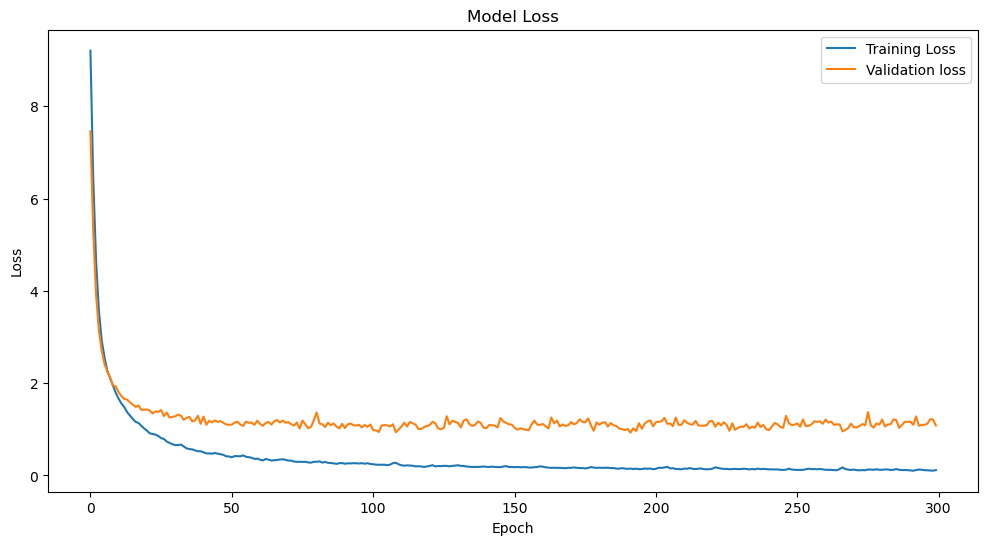

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
#plt.savefig('TL-Loss-3-modalities.jpg')
plt.show()

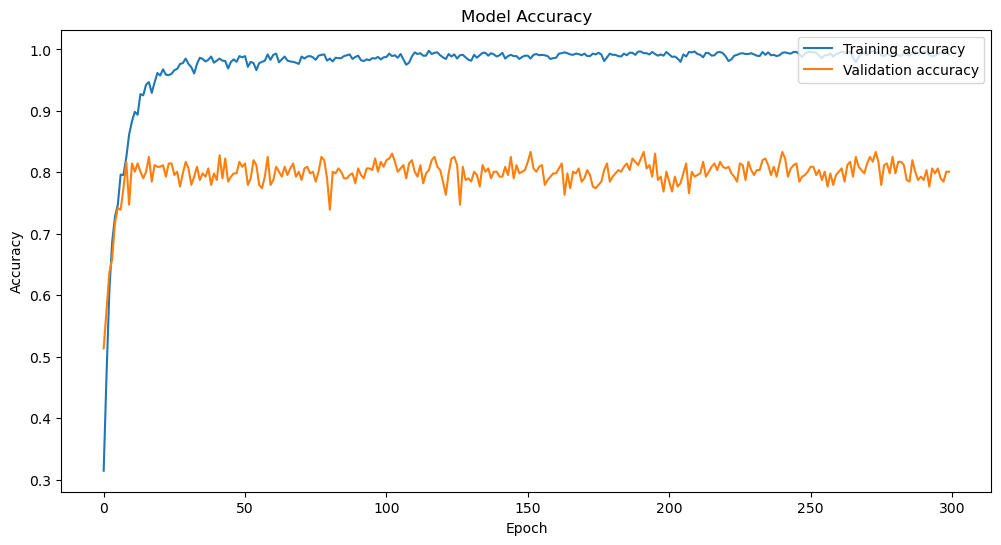

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
#plt.savefig('TL-accuracy-modalities.jpg')
plt.show()